# Duplicate document comparison

Each parlamentary session produces: 
- different types of documents (for example a session protocol and a word protocol) 
- in one (the word protocol is a singular mulitlingual document without translations) or more languages (the session protocol is translated into 24 languages) 
- in different file formats (.pdf, .html and .doc)

This document compares the already scraped session and word protocols.

Each were scraped as a .html- and .pdf-file in English and German.

Unfortunately there is some data missing for the pdf-files, as the postprocessing process for them hasn't finished yet.


In [1]:
from europarl.db import DBInterface
import configparser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt


from matplotlib.pyplot import figure

In [2]:
config = configparser.ConfigParser()
config.read('settings.ini')
dbi = DBInterface(config=config["General"])

In [3]:
def get_text_length_per_session_date(rules):
    results = {}
    for rule in rules :
        query = """ SELECT char_length(data ->> 'content') as fs, data ->> 'session_date' as date
                    FROM documents
                    WHERE data ->> 'rulename' =%s
                    ORDER by date DESC
                """
        with dbi.cursor() as db:
            db.cur.execute(
                query,
                [rule,],
            )
            res = db.cur.fetchall()

        res = list(zip(*res))

        x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in res[1]]
        y = [int(value or 0) for value in res[0]]

        results[rule]=(x,y)
    return results
        
def plot_text_length_per_session_date(data, rules):

    years = mdates.YearLocator(5)   # every year
    year = mdates.MonthLocator(1)  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(4)
    fig.set_size_inches(18, 16)
    
    plt.subplots_adjust(hspace=0.4)

    datemin, datemax = None, None

    for index, rule in enumerate(rules):
        x,y = data[rule]
        ax[index].plot(x,y)

        if datemin is None:
            datemin = min(x)
        elif min(x) < datemin:
            datemin = min(x)

        if datemax is None:
            datemax = max(x)
        elif max(x) > datemax:
            datemax = max(x)

        ax[index].set_title(rule)
        ax[index].set(ylabel='characters per document', xlabel='date of the document')
        ax[index].xaxis.set_major_locator(years)
        ax[index].xaxis.set_major_formatter(years_fmt)
        ax[index].xaxis.set_minor_locator(year)
        ax[index].set_xlim(datemin, datemax)


## Comparing protocol character counts


Session protocols are available in .html starting in spring 2003 and as .pdf-files all the way back to winter 1994.

Word procotcols are available in both formats back to winter 1994

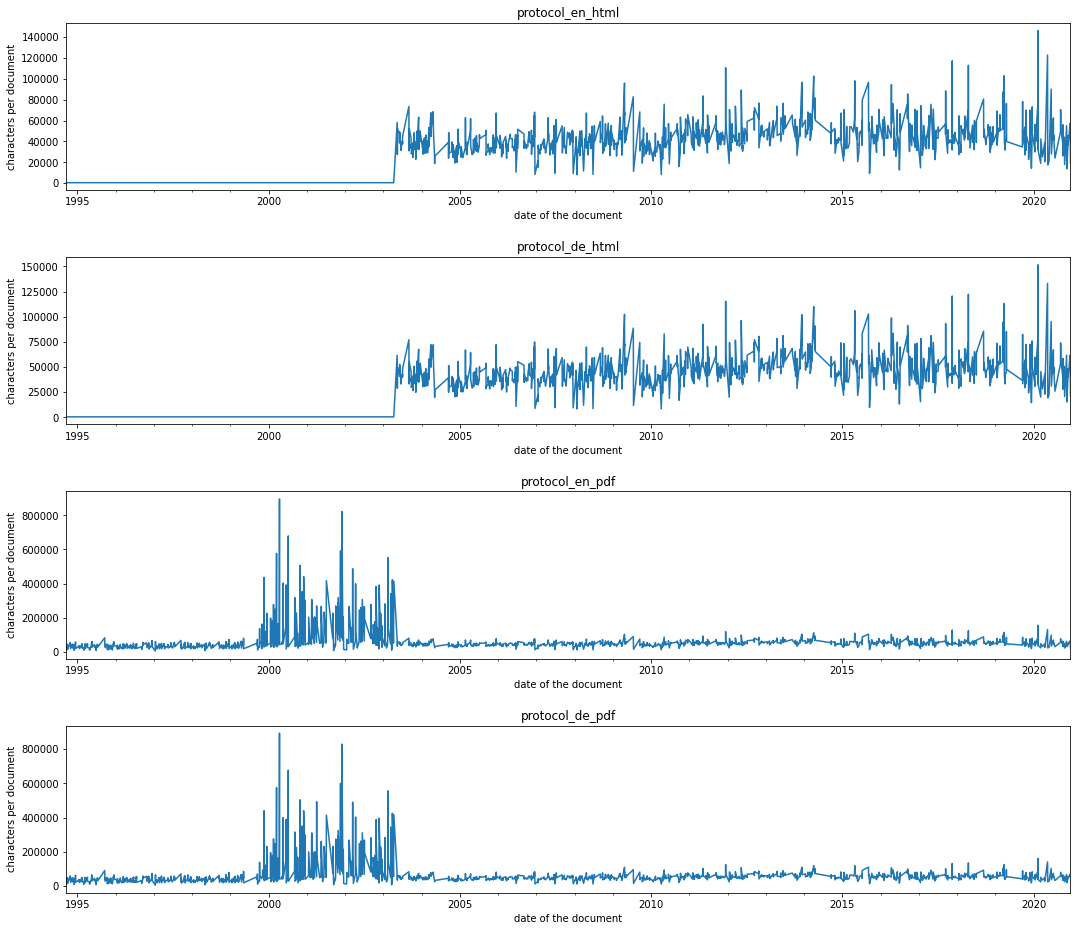

In [4]:
rules = ['protocol_en_html', 'protocol_de_html', 'protocol_en_pdf', 'protocol_de_pdf']

data = get_text_length_per_session_date(rules)
plot_text_length_per_session_date(data, rules)

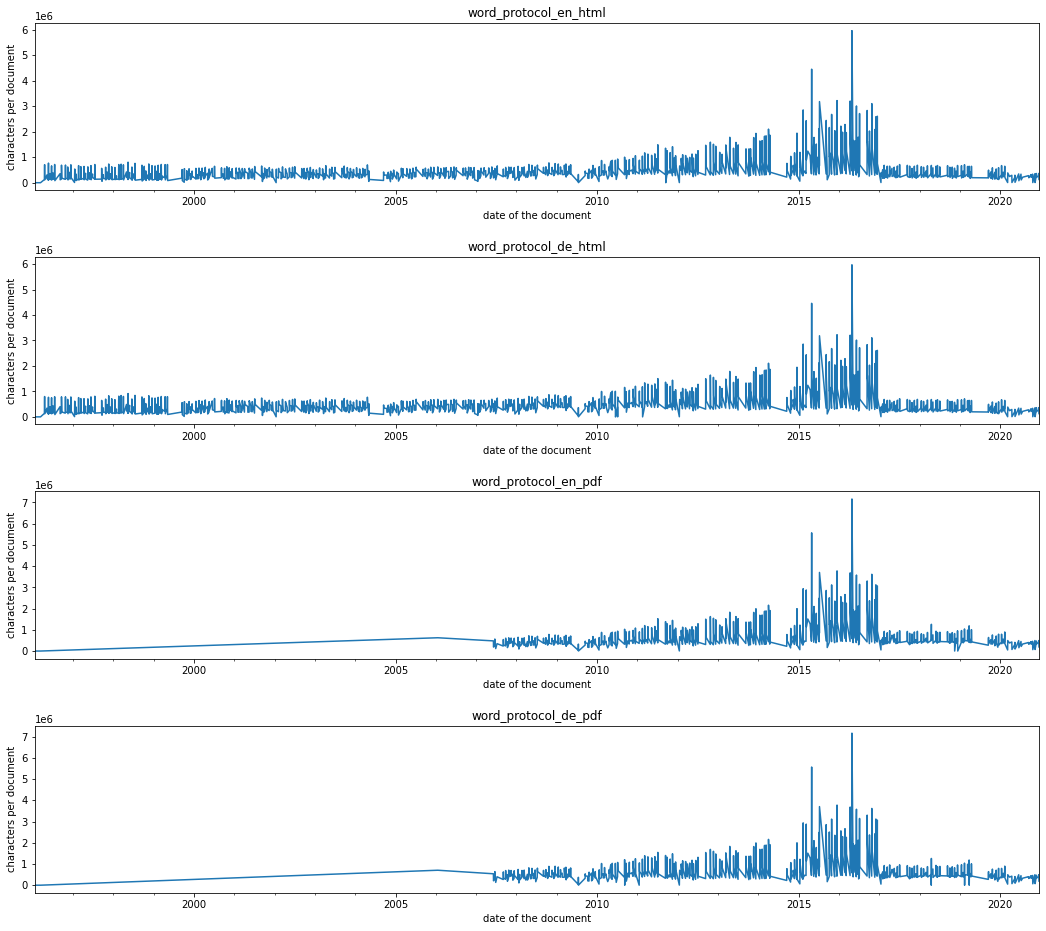

In [5]:
rules = ['word_protocol_en_html', 'word_protocol_de_html', 'word_protocol_en_pdf', 'word_protocol_de_pdf']

data = get_text_length_per_session_date(rules)
plot_text_length_per_session_date(data, rules)

In [6]:
from difflib import SequenceMatcher

def get_texts(rules):
    query = """ SELECT res1.date, res1.text, res2.text FROM
                    (
                        SELECT data ->> 'content' as text, data ->> 'session_date' as date 
                        FROM documents 
                        WHERE data ->> 'rulename' = %s
                    ) res1
                JOIN (
                        SELECT data ->> 'content' as text, data ->> 'session_date' as date 
                        FROM documents 
                        WHERE data ->> 'rulename' = %s
                    ) res2
                ON res1.date = res2.date
                ORDER by res1.date DESC"""
         
    
    with dbi.cursor(name='exploration', withhold=True) as db:
        db.cur.execute(
            query,
            [rules[0],rules[1]],
        )
        yield from db.cur

def compute_similiarities(rule_pairs):
    results = {}
    for pair in rule_pairs:
        texts = get_texts(pair)
        dates =[]
        similiarity = []

        name = pair[0] + " " + pair[1]

        for i, res in enumerate(texts):
                
            dates.append(dt.datetime.strptime(res[0],'%Y-%m-%d').date())
            similiarity.append(SequenceMatcher(None, (res[1] or " "), (res[2] or " ")).real_quick_ratio())

        results[name]={'dates': dates, 'similiarity': similiarity}
        print("Computed {}".format(name))

    return results  

def plot_text_similiarity(data):

    years = mdates.YearLocator(5)   # every year
    year = mdates.MonthLocator(1)  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(4)
    fig.set_size_inches(18, 16)
    
    plt.subplots_adjust(hspace=0.4)

    datemin, datemax = None, None

    for index, key in enumerate(data):
        x = data[key]['dates']
        y = data[key]['similiarity']
        ax[index].scatter(x,y)

        if datemin is None:
            datemin = min(x)
        elif min(x) < datemin:
            datemin = min(x)

        if datemax is None:
            datemax = max(x)
        elif max(x) > datemax:
            datemax = max(x)

        ax[index].set_title(key)
        ax[index].set(ylabel='sequence matcher ration of the documents', xlabel='date of the document')
        ax[index].xaxis.set_major_locator(years)
        ax[index].xaxis.set_major_formatter(years_fmt)
        ax[index].xaxis.set_minor_locator(year)
        ax[index].set_xlim(datemin, datemax)

In [7]:
rule_pairs = [('protocol_en_html','protocol_en_pdf'), ('protocol_de_html','protocol_de_pdf'), ('word_protocol_en_html','word_protocol_en_pdf'), ('word_protocol_de_html','word_protocol_de_pdf')]

results = compute_similiarities(rule_pairs)

Computed protocol_en_html protocol_en_pdf
Computed protocol_de_html protocol_de_pdf
Computed word_protocol_en_html word_protocol_en_pdf
Computed word_protocol_de_html word_protocol_de_pdf


## Text similiarity between file formats

Using ```SequenceMatcher.real_quick_ratio()``` as a heuristic for documents shows relatively good sequence matching between the extracted texts from the different file formats (mind the x-axis caused by still running .pdf-postprocessing). Outliers to 0 are caused by unreadable .pdf-files. Further investigation is needed here.

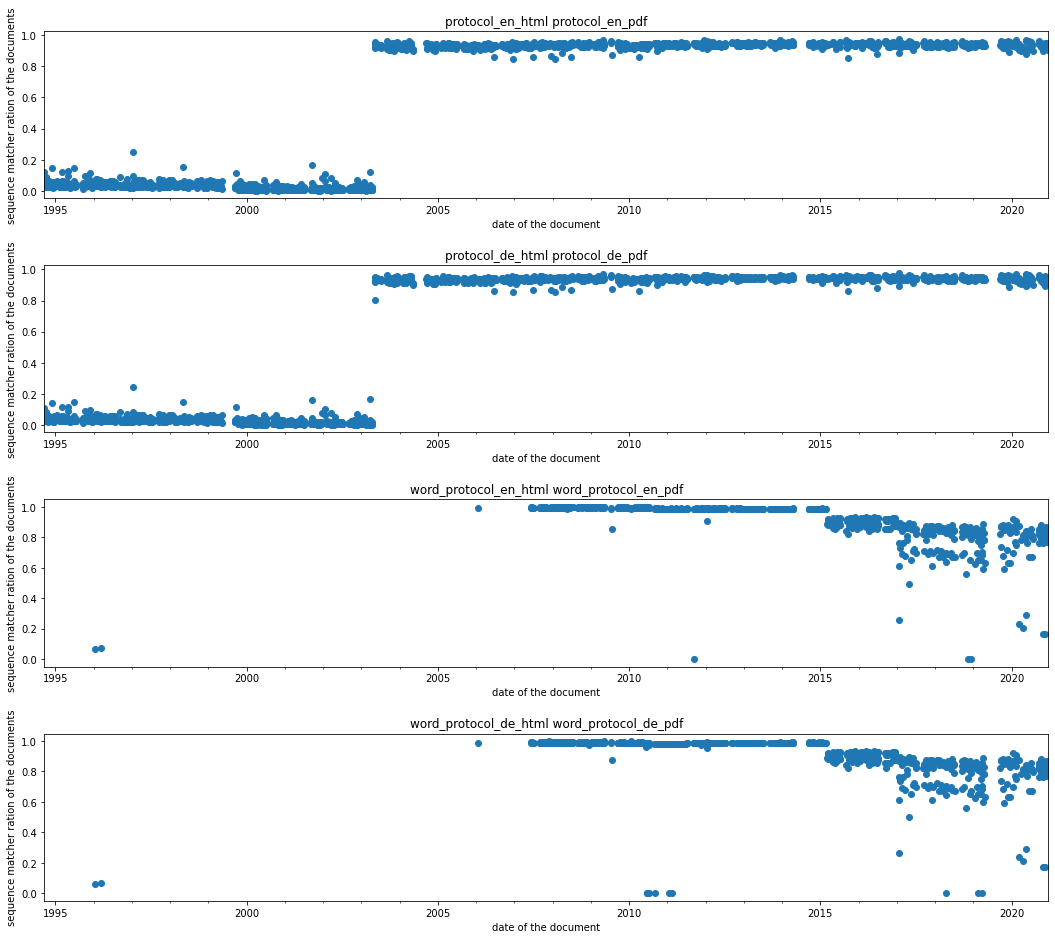

In [8]:
plot_text_similiarity(results)

## Mapping design options

### Choosing the best format

We have to assume that .pdf and .html-files contain the same information, therefore we can assume that the extracted text from .html-files is more reliable as the text extracted from .pdf files.

We therefore index only one variant, preferably .html but falling back to .pdf using only one language
```
{
    content: "Alle meine Entchen...",
    language: "DE",
    filetype: ".html",
    session_date: "01.01.2022",
    document_type: "protocol"
}
```

### Denormalization

#### Choosing all formats

We do not want to make assumptions about file content. We therefore index all available file variants in only one language.
```
{
    content_html: "Alle meine Entchen...",
    content_pdf: "Heute back ich, morgen brau ich,...",
    language: "DE",
    session_date: "01.01.2022",
    document_type: "protocol"
}
```

#### Choosing all formats and languages

We do not want to make assumptions about file content and want to make queries in multiple languages 
```
{
    content_de_html: "Alle meine Entchen...",
    content_en_html: "All my little ducklings...",
    content_de_pdf: "Heute back ich, morgen brau ich,...",
    content_en_pdf: "Today I bake, tomorrow i brew, ...",
    session_date: "01.01.2022",
    document_type: "protocol"
}
```

### Nested

Nesting documents into a parent documents. Comes with query limitations and every subdocument is stored in the same Lucene block (shouldn't be a problem because we aren't changing data after the initial indexing).

```
{
    session_date: "01.01.2022",
    document_type: "protocol",
    docs:[
        {
            content: "Alle meine Entchen...",
            language: "DE",
            filetype: ".html",
        },
        {
            content: "All my little ducklings...",
            language: "EN",
            filetype: ".html",
        }
    ]
}
```

### Parent/Child

Two different types of parent- and child-documents, letting Elasticsearch manage the relationship between them. Lower query performance and higher memory usage 





### Pros and Cons 

List of pros and cons as provided from [Elasticsearch](https://www.elastic.co/de/blog/managing-relations-inside-elasticsearch):

#### Nested
- Nested docs are stored in the same Lucene block as each other, which helps read/query performance. Reading a nested doc is faster than the equivalent parent/child.
- Updating a single field in a nested document (parent or nested children) forces ES to reindex the entire nested document. This can be very expensive for large nested docs
- "Cross referencing" nested documents is impossible
- Best suited for data that does not change frequently

#### Parent/Child

- Children are stored separately from the parent, but are routed to the same shard. So parent/children are slightly less performance on read/query than nested
- Parent/child mappings have a bit extra memory overhead, since ES maintains a "join" list in memory
- Updating a child doc does not affect the parent or any other children, which can potentially save a lot of indexing on large docs
- Sorting/scoring can be difficult with Parent/Child since the Has Child/Has Parent operations can be opaque at times

#### Denormalization

- You get to manage all the relations yourself!
- Most flexible, most administrative overhead
- May be more or less performant depending on your setup